In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import seaborn as sns
from matplotlib.pyplot import figure, show
import matplotlib.style as style

from scipy import stats
# Any results you write to the current directory are saved as output.

style.use('seaborn-poster') #sets the size of the charts
style.use('fivethirtyeight')
# --- 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

['WA_Fn-UseC_-Telco-Customer-Churn.csv']


In [2]:
# load data
users = pd.read_csv("../input/WA_Fn-UseC_-Telco-Customer-Churn.csv")
users.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


36.122922303826826

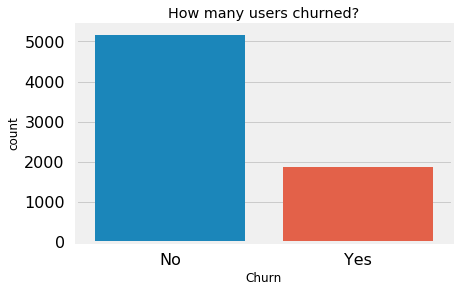

In [3]:
# let's look at the response variable, is it unbalanced?
sns.countplot(x = "Churn", data=users).set_title("How many users churned?")
# as expected it is unbalanced, not heavily
users.Churn[users.Churn=="Yes"].shape[0]/users.Churn[users.Churn=="No"].shape[0]*100 #36.12% has churned.

Text(0.5,1,'Relationship between gender and Churn')

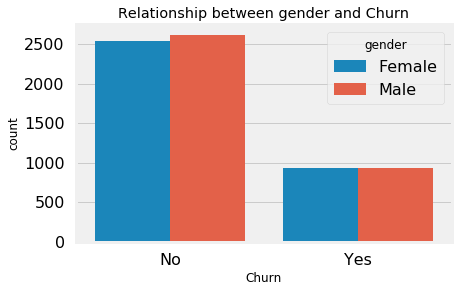

In [4]:
# gender vs churn, is there a relation?
sns.countplot(x="Churn", data=users, hue="gender").set_title("Relationship between gender and Churn")
# it seems that gender is not related with churn, otherwise I'd expect to see different ratios

In [5]:
# here a crosstab, I want to exclude with Chisq the possible relationship
cross_tab = pd.crosstab(users.Churn, users.gender)
print(cross_tab)

g, p, dof, expctd = stats.chi2_contingency(cross_tab)
print(g) # statistics value
print(p) # pvalue > 0.05 -> H0 is not rejected, we can say that there's no apparent relationship.

gender  Female  Male
Churn               
No        2549  2625
Yes        939   930
0.4840828822091383
0.48657873605618596


Text(0.5,1,'Types of Contract avaiable')

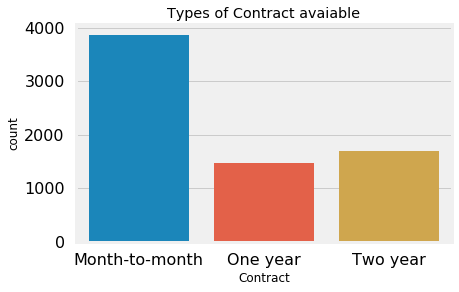

In [6]:
# which types of contract are avaiable? 
sns.countplot(x="Contract", data=users).set_title("Types of Contract avaiable")
# is there a relationship with Churn?

Contract  Month-to-month  One year  Two year
Churn                                       
No                  2220      1307      1647
Yes                 1655       166        48
1184.5965720837926
5.863038300673391e-258


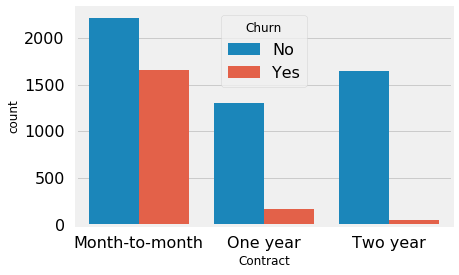

In [7]:
sns.countplot(x="Contract", data=users, hue="Churn")
# it seems that Churn is more probable with shorter Contracts, which is not that surprising.
cross_tab = pd.crosstab(users.Churn, users.Contract)
print(cross_tab)

g, p, dof, expctd = stats.chi2_contingency(cross_tab)
print(g)
print(p) # pvalue < 0.05 -> H0 is rejected, we can assume that in fact there's a relationship with Contract and Churn
#print(expctd)

Text(0.5,1,'PaymentMethod vs Churn')

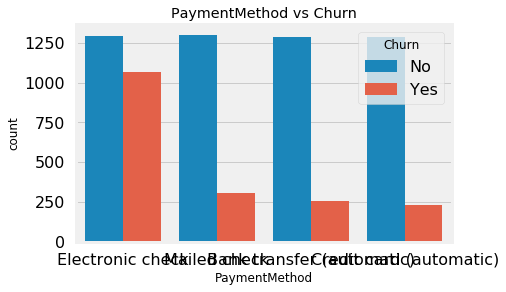

In [8]:
# compared to the PaymentMethod, how is the Churn rate?
sns.countplot(x="PaymentMethod", data=users, hue="Churn").set_title("PaymentMethod vs Churn")
# again we can see a different pattern based on PaymentMethod.

In [11]:
# we could get a new variable: TotalCharges/tenure
# this should help understand the relationship between amount payed by billing and Churn

# there seems to be somethin wrong with the TotalCharges columns, maybe it's just a wrong format problem.
#users.TotalCharges_num = pd.to_numeric(users.TotalCharges) # error

# looks like we have some empty value
#users[users.TotalCharges==" "] 
# for the moment I'll remove this values, because they seem either anomalous or non relevant, maybe
users_new = users[users.TotalCharges!=" "].copy()

users_new["TotalCharges_num"] = users_new["TotalCharges"].astype(float)
print(users_new.head())
#users["billed_bytenure"] = users.TotalCharges / users.tenure
#users.head()

   customerID  gender       ...         Churn TotalCharges_num
0  7590-VHVEG  Female       ...            No            29.85
1  5575-GNVDE    Male       ...            No          1889.50
2  3668-QPYBK    Male       ...           Yes           108.15
3  7795-CFOCW    Male       ...            No          1840.75
4  9237-HQITU  Female       ...           Yes           151.65

[5 rows x 22 columns]


In [12]:
users_new["billed_bytenure"] = users_new.TotalCharges_num / users_new.tenure
users_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_num,billed_bytenure
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,29.85,29.850000
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No,1889.50,55.573529
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,108.15,54.075000
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1840.75,40.905556
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,151.65,75.825000


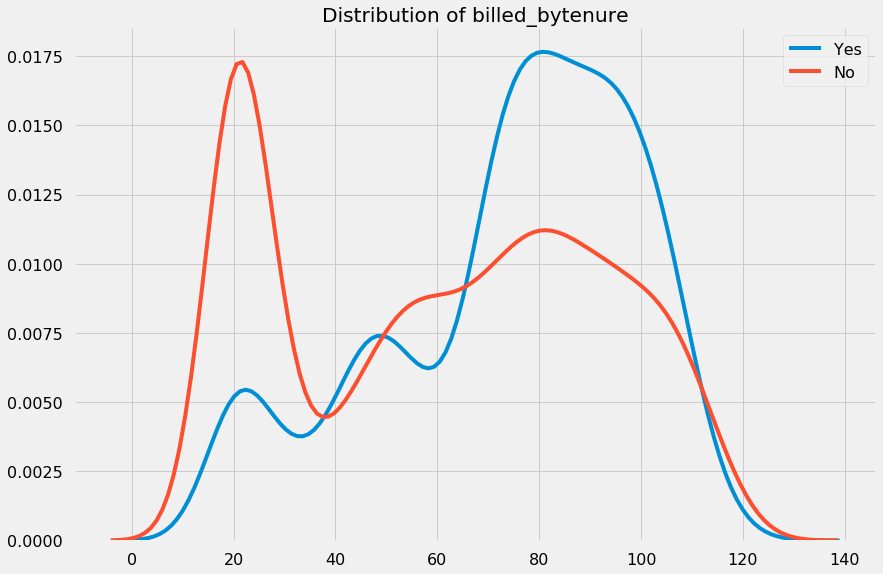

In [13]:
# lets make some plot
user_churn = users_new.loc[users_new.Churn=="Yes"]
user_nochurn = users_new.loc[users_new.Churn=="No"]

sns.distplot(user_churn[["billed_bytenure"]], hist=False, kde=True, label="Yes").set_title("Distribution of billed_bytenure")
sns.distplot(user_nochurn[["billed_bytenure"]], hist=False, kde=True, label="No")
# it seems that the distribution for those who churned tends to have a higher mode (higher costs), than for those users who haven't churned yet.

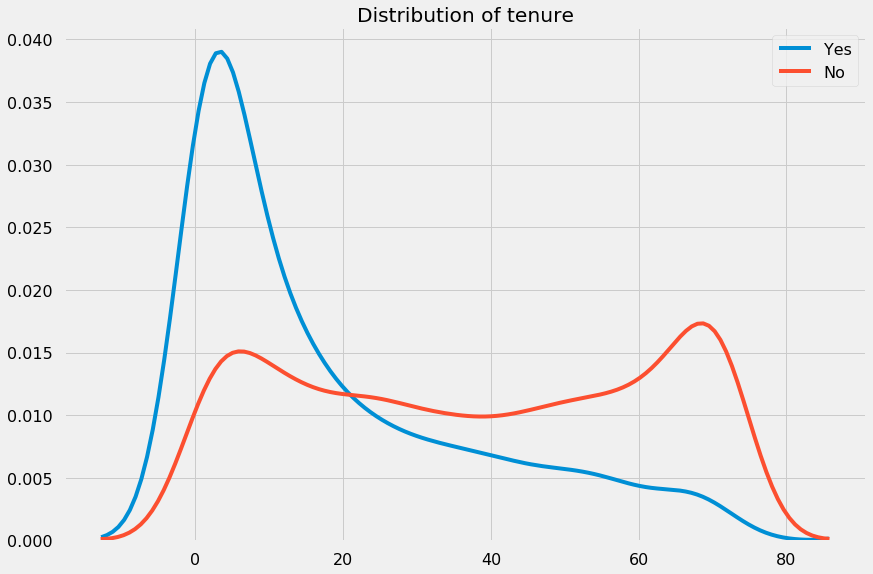

In [14]:
sns.distplot(user_churn[["tenure"]], hist=False, kde=True, label="Yes").set_title("Distribution of tenure")
sns.distplot(user_nochurn[["tenure"]], hist=False, kde=True, label="No")
# has expected the distribution for tenure is right skewed for "No" (people that Churn stay less)

In [15]:
# Data Processing --- curtesy of pavanraj159 notebook (kaggle kernel)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols = users_new.nunique()[users_new.nunique() < 6].keys().tolist()
cat_cols = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols = [x for x in users_new.columns if x not in cat_cols + target_col + Id_col]
#binary columns 
bin_cols = users_new.nunique()[users_new.nunique() == 2].keys().tolist()
#columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

# label encoding binary columns
le = LabelEncoder()
for i in bin_cols:
    users_new[i] = le.fit_transform(users_new[i]) # applico l'encoder solo su cols specifiche
# this helps trasform in binary vaules (0,1) each binary cols

# duplicating cols for multi value cols
users_new = pd.get_dummies(data=users_new, columns = multi_cols)
users_new.head()
# with this i created new dummy cols that cover multiple values cols

# scaling for numerical cols
std = StandardScaler()
scaled = std.fit_transform(users_new[num_cols])
scaled = pd.DataFrame(scaled, columns=num_cols)

#drop original values merging scaled values for numerical cols
users_df = users_new.copy()
users_new = users_new.drop(columns=num_cols, axis=1)
users_new = users_new.merge(scaled, left_index=True,right_index=True,how="left")
users_new.head()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,TotalCharges_num,billed_bytenure
0,7590-VHVEG,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,-1.280248,-1.161694,-0.994194,-0.994194,-1.157889
1,5575-GNVDE,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0.064303,-0.260878,-0.173740,-0.173740,-0.305658
2,3668-QPYBK,1,0,0,0,1,1,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,-1.239504,-0.363923,-0.959649,-0.959649,-0.355305
3,7795-CFOCW,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0.512486,-0.747850,-0.195248,-0.195248,-0.791614
4,9237-HQITU,0,0,0,0,1,1,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,-1.239504,0.196178,-0.940457,-0.940457,0.365282


In [16]:
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization

# correlation matrix --- curtesy of pavanraj159 notebook (kaggle kernel)
correlation = scaled.corr()
# tick labels
matrix_cols = correlation.columns.tolist()
# convert to array
corr_array = np.array(correlation)

# viz
trace = go.Heatmap(z = corr_array,
                  x = matrix_cols,
                  y = matrix_cols,
                  colorscale = "Viridis",
                  colorbar = dict(title="Correlations Legend",
                                 titleside = "right"),
                  )
layout = go.Layout(dict(title="Correlation Matrix",
                       autosize = False,
                       height = 720,
                       width = 800,
                       margin = dict(r=0,l=210,
                                    t=25,b=210,
                                    ),
                        yaxis = dict(tickfont=dict(size=9)),
                        xaxis = dict(tickfont=dict(size=9))
                       )
                  )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [17]:
# model and LIME viz
users_new.head()
# here we have the dataset with dummy and scaled numerics. "Churn" is the response

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,TotalCharges_num,billed_bytenure
0,7590-VHVEG,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,-1.280248,-1.161694,-0.994194,-0.994194,-1.157889
1,5575-GNVDE,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0.064303,-0.260878,-0.173740,-0.173740,-0.305658
2,3668-QPYBK,1,0,0,0,1,1,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,-1.239504,-0.363923,-0.959649,-0.959649,-0.355305
3,7795-CFOCW,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0.512486,-0.747850,-0.195248,-0.195248,-0.791614
4,9237-HQITU,0,0,0,0,1,1,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,-1.239504,0.196178,-0.940457,-0.940457,0.365282


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

data = users_new.copy().dropna()
X = data.drop(["customerID", "Churn"], axis=1)
#X.columns
y = data.Churn

# split train-test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

# model build
rfc = RandomForestClassifier(n_estimators=100, random_state=123)
rfc.fit(X_train, y_train)

predicted = rfc.predict(X_test)
print("Precision : ", precision_score(y_test, predicted))
print("Recall : ", recall_score(y_test, predicted))

Precision :  0.6122004357298475
Recall :  0.42255639097744363


(0.0, 1.0)

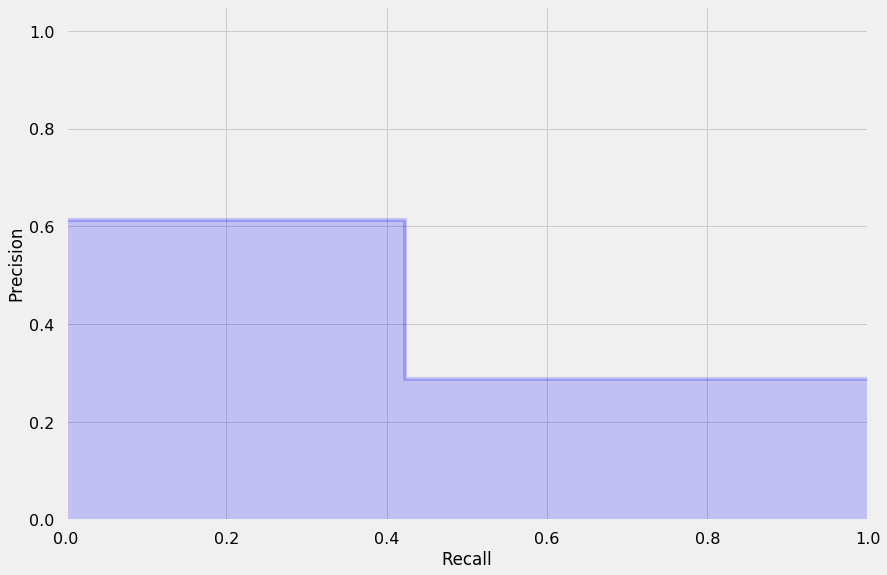

In [78]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
precision, recall, _ = precision_recall_curve(y_test, predicted)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

In [91]:
import lime
from lime.lime_tabular import LimeTabularExplainer

predict_fn_rf = lambda x: rfc.predict_proba(x).astype(float)
# build lime explainer
explainer = LimeTabularExplainer(X_train, mode='classification', 
                                 feature_names=X_train.columns, 
                                 random_state=13, 
                                 discretize_continuous=False) 

test_X_imp_df = pd.DataFrame(X_test, columns=X_test.columns)
num_features = len(X_test.columns)

# explain single instance
exp_idx = 30
exp = explainer.explain_instance(test_X_imp_df.iloc[exp_idx,:].values, 
                                 predict_fn_rf, num_features=num_features)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.



0.05273646005966029


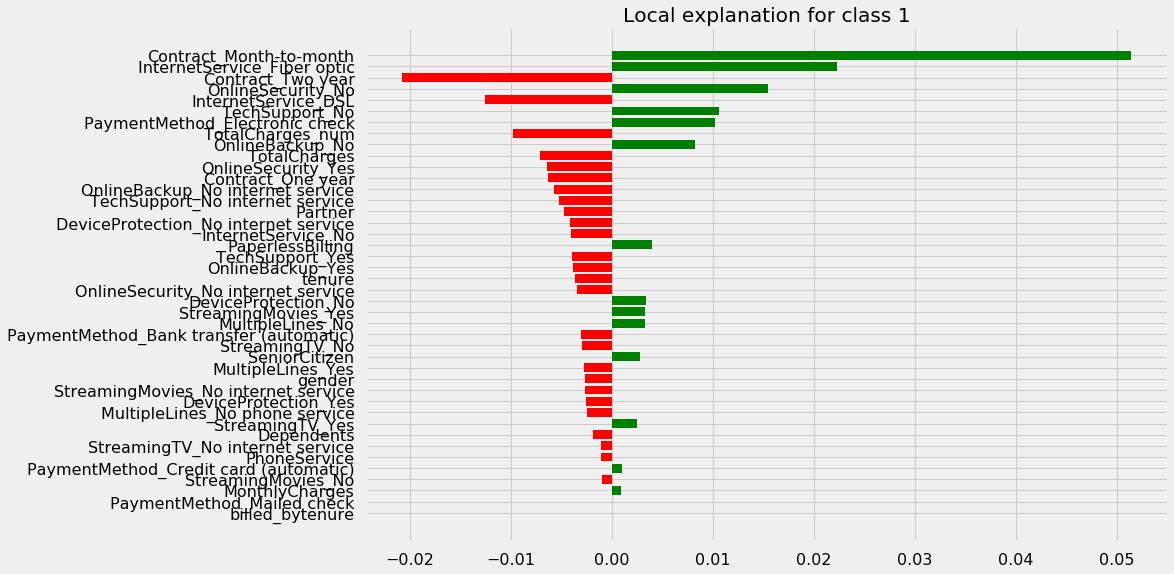

In [93]:
# viz
print(exp.local_pred[0])
exp.as_pyplot_figure();

0.23640861010542913


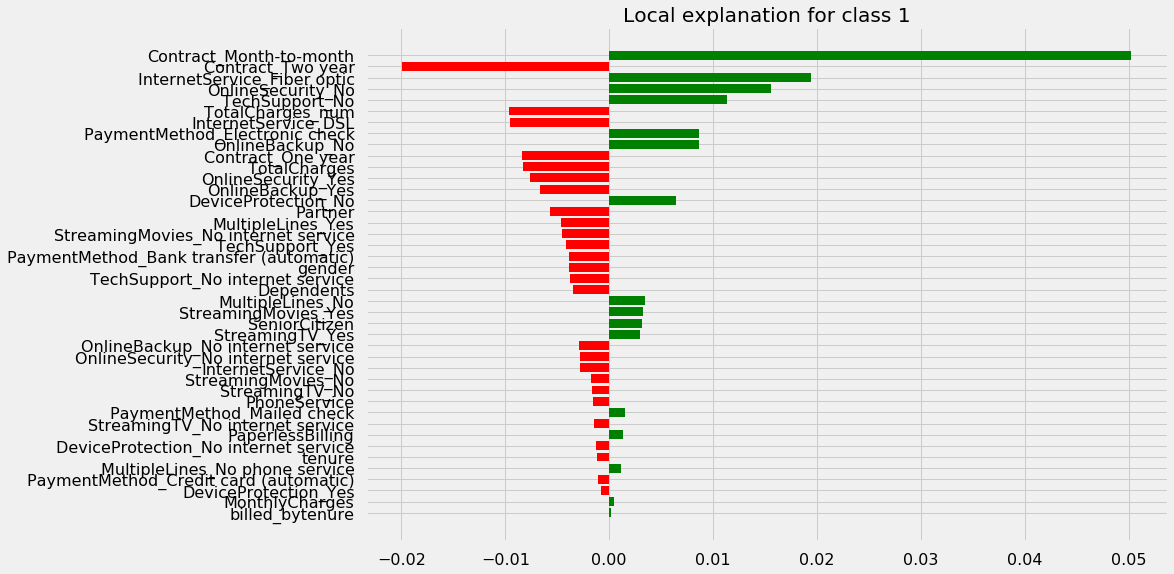

In [96]:
exp_idx = 100
exp = explainer.explain_instance(test_X_imp_df.iloc[exp_idx,:].values, 
                                 predict_fn_rf, num_features=num_features)
print(exp.local_pred[0])
exp.as_pyplot_figure();

0.4021110747060057


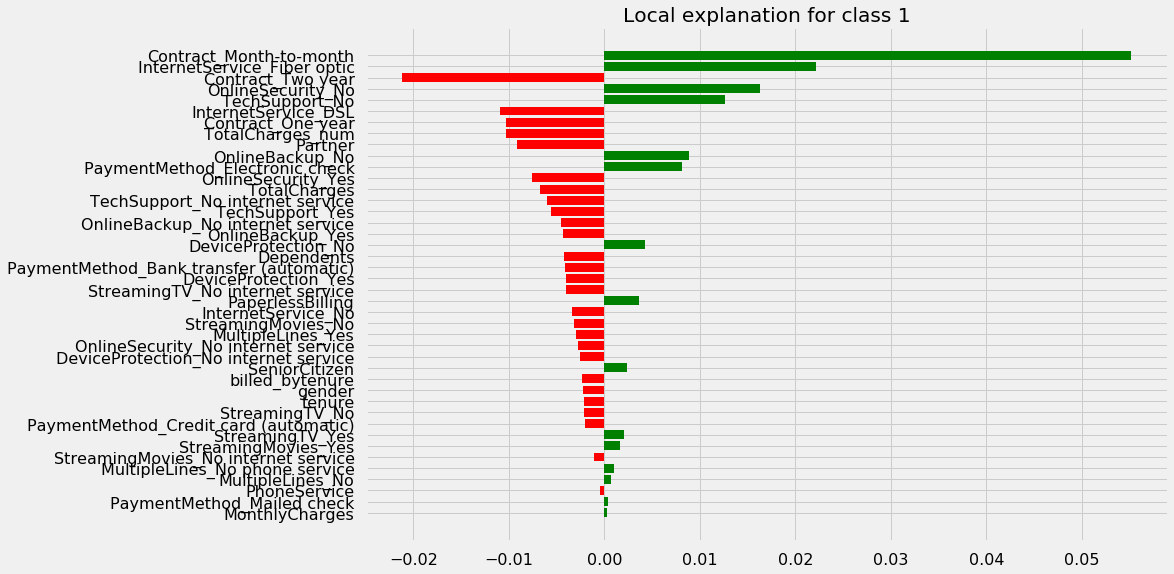

In [97]:
exp_idx = 1000
exp = explainer.explain_instance(test_X_imp_df.iloc[exp_idx,:].values, 
                                 predict_fn_rf, num_features=num_features)
print(exp.local_pred[0])
exp.as_pyplot_figure();

0.1433163383307099


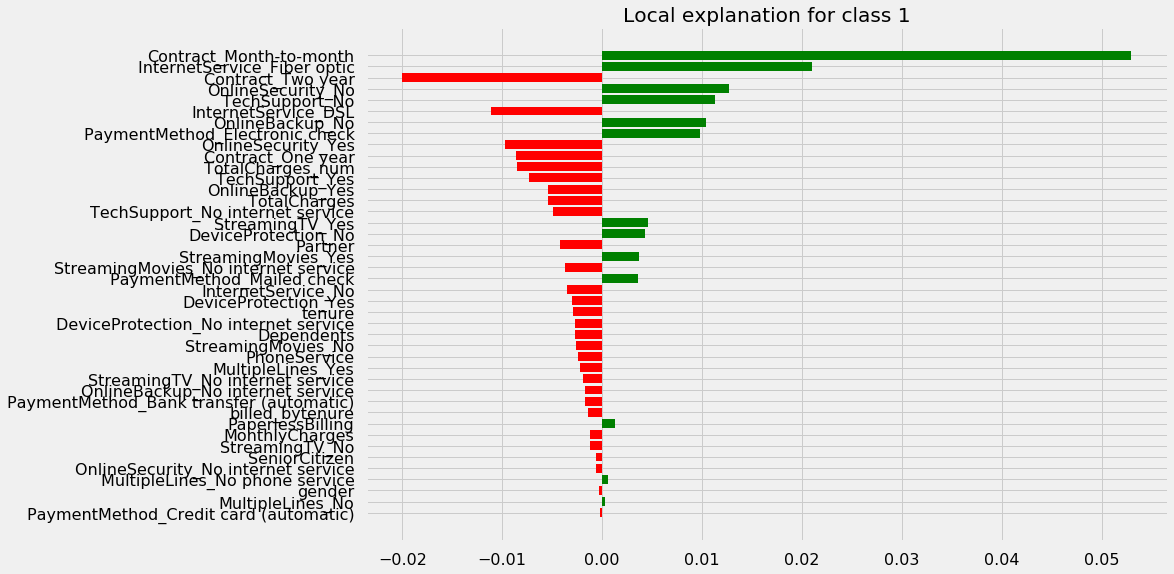

In [107]:
#np.where(predicted == 1) # 115 - 167 - 171

#probs = rfc.predict_proba(X_test).astype(float)
#np.argmax(probs) 8

exp_idx = 8
exp = explainer.explain_instance(test_X_imp_df.iloc[exp_idx,:].values, 
                                 predict_fn_rf, num_features=num_features)
print(exp.local_pred[0])
exp.as_pyplot_figure();